In [1]:
import torch
import numpy as np
import scipy.io as sio
import os
import time
from scipy import stats

In [18]:
class EnsemblePursuitPyTorch():
    
    def zscore(self):
        mean_stimuli=self.X.mean(dim=0)
        std_stimuli=self.X.std(dim=0)+0.0000000001
        
        self.X=torch.sub(self.X,mean_stimuli)
        self.X=self.X.div(std_stimuli)
    
    def calculate_cost_delta(self):
        cost_delta=(torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)**2)/(self.sz[0]*torch.matmul(self.current_v,self.current_v))-self.lambd
        #print('cost delta',cost_delta.mean())
        return cost_delta
    
    def fit_one_assembly(self):
        '''
        Function for fitting one cell assembly and computing u and v of the currrent assembly (self.current_u,
        self.current_v).
        One neuron cell assemblies are excluded. 
        '''
        with torch.cuda.device(0) as device:
            #Fake i for initiating while loop. self.i stores the number of neurons in assemblies.
            self.i=7
            #If i is 1, e.g. only one neuron in fit cell assembly, will run fitting the assembly again. 
            #safety it to avoid infinite loops.
            safety_it=0
            n_of_neurons=self.neuron_init_dict['parameters']['n_of_neurons']
            min_assembly_size=self.neuron_init_dict['parameters']['min_assembly_size']
            #Correlate correlation matrix if top_k_corr method of assembly initialization, because
            #then sampling will be better
            if self.neuron_init_dict['method']=='top_k_corr':
                self.for_sampling,self.vals=self.corr_top_k(n_neurons=n_of_neurons)
            #Reject assemblies with less than 8 neurons
            while self.i<min_assembly_size:
                if self.first_assembly==True:
                    top_neurons=self.select_top_neurons()
                elif self.first_assembly==False and self.neuron_init_dict['method']=='from_time_point':
                    self.neuron_init_dict['method']='top_k_corr'
                    top_neurons=self.select_top_neurons()
                elif self.first_assembly==False:
                    top_neurons=self.select_top_neurons()
                #Array of keeping track of neurons in the cell assembly
                self.selected_neurons=torch.zeros([self.sz[1]]).cuda()
                for j in range(0,len(top_neurons)):
                    self.selected_neurons[top_neurons[j]]=1
                #Seed current_v
                self.current_v=self.X[:,top_neurons].mean(1).flatten()
                #Fake cost to initiate while loop
                max_delta_cost=1000
                #reset i
                self.i=1
                #while max_delta_cost>0 and self.i<=1000:
                while max_delta_cost>0:
                    cost_delta=self.calculate_cost_delta()
                    #invert the 0's and 1's in the array which stores which neurons have already 
                    #been selected into the assembly to use it as a mask
                    mask=self.selected_neurons.clone()
                    mask[self.selected_neurons==0]=1
                    mask[self.selected_neurons!=0]=0
                    masked_cost_delta=mask*cost_delta
                    values,sorted_neurons=masked_cost_delta.sort()
                    max_delta_neuron=sorted_neurons[-1]
                    max_delta_cost=values[-1]
                    if max_delta_cost>0:
                        self.selected_neurons[max_delta_neuron.item()]=1
                        self.current_v= self.X[:, (self.selected_neurons == 1)].mean(dim=1)
                        #print('sel neurons', self.X[:, (self.selected_neurons == 1)].size())
                    self.i+=1
                safety_it+=1
                #Increase number of neurons to sample from if while loop hasn't been finding any assemblies.
                if safety_it>100:
                    self.neuron_init_dict['parameters']['n_of_neurons']=500
                    if self.neuron_init_dict['method']=='top_k_corr':
                        self.for_sampling,self.vals=self.corr_top_k(n_neurons=500)
                if safety_it>600:
                    self.neuron_init_dict['parameters']['n_of_neurons']=1000
                    if self.neuron_init_dict['method']=='top_k_corr':
                        self.for_sampling,self.vals=self.corr_top_k(n_neurons=1000)
                if safety_it>1600:
                    raise ValueError('Assembly capacity too big, can\'t fit model')
            #Once one assembly has been found, set the variable to false
            self.first_assembly=False
            #Add final seed neuron to seed_neurons.        
            self.seed_neurons=self.seed_neurons+top_neurons          
            #Calculate u based on final v fit for a cell assembly. 
            self.current_u=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)/torch.matmul(self.current_v,self.current_v)
            self.U=torch.cat((self.U,self.current_u.view(self.X.size(1),1)),1)
            self.V=torch.cat((self.V,self.current_v.view(1,self.X.size(0))),0)
            
    def select_top_neurons(self):
        if self.neuron_init_dict['method']=='top_k_corr':
            n_of_neurons=self.neuron_init_dict['parameters']['n_of_neurons']
            top_neurons=self.select_top_k_corr_neuron(self.for_sampling,self.vals,n_of_neurons)
        if self.neuron_init_dict['method']=='random':
            top_neurons=[np.random.randint(0,self.sz[1],1)[0]]
        if self.neuron_init_dict['method']=='from_time_point':
            top_neurons=self.select_from_time_point()
        return top_neurons
    
    def select_from_time_point(self):
        threshold=self.neuron_init_dict['parameters']['T']
        threshold_array=(self.original_X>=threshold).sum(dim=1)
        #print('thr_array',threshold_array)
        values,sorted_timepoints=threshold_array.sort()
        timepoint=sorted_timepoints[-1]
        #print('t',timepoint)
        neurons=(self.original_X[timepoint,:]>=threshold).nonzero()
        #print('neurons',neurons)
        return neurons.tolist()
    
    def corrcoef(self,x):
        '''
        Torch implementation of the full correlation matrix.
        '''
        # calculate covariance matrix of columns
        mean_x = torch.mean(x,0)
        xm = torch.sub(x,mean_x)
        c = x.mm(x.t())
        c = c / (x.size(1))

        # normalize covariance matrix
        d = torch.diag(c)
        stddev = torch.pow(d, 0.5)
        c = c.div(stddev.expand_as(c))
        c = c.div(stddev.expand_as(c).t())
        #print((c!=c).nonzero())
        # clamp between -1 and 1
        c = torch.clamp(c, -1.0, 1.0)

        return c
    
    def corr_top_k(self,n_neurons=100):
        '''
        Finds n_neurons neurons that are on average most correlated to their 
        5 closest neighbors.
        '''
        #Compute full correlation matrix (works with one neuron per column,
        #so have to transpose.)
        corr=self.corrcoef(self.X.t())
        #Sorts each row of correlation matrix
        vals,ix=corr.sort(dim=1)
        #Discards the last entry corresponding to the diagonal 1 and then
        #selects 5 of the largest entries from sorted array.
        top_vals=vals[:,:-1][:,self.sz[1]-6:]
        #Averages the 5 top correlations.
        av=torch.mean(top_vals,dim=1)
        #Sorts the averages
        vals,top_neurons=torch.sort(av)
        #Selects top neurons
        top_neuron=top_neurons[self.sz[1]-(n_neurons+1):]
        top_val=vals[self.sz[1]-(n_neurons+1):]
        return top_neuron,top_val
          
    
    def select_top_k_corr_neuron(self,top_neuron,top_val,n_neurons=100):
        '''
        Randomly samples from k top correlated urons.
        '''
        #Randomly samples a neuron from the n_of_neurons top correlated.
        idx=torch.randint(0,n_neurons,size=(1,))
        print('top n', top_neuron[idx[0]].item(), top_val[idx[0]].item())
        return [top_neuron[idx[0]].item()]
    
    
    def fit_transform(self,X,lambd,n_ensembles,neuron_init_dict):
        torch.manual_seed(7)
        with torch.cuda.device(0) as device:
            self.neuron_init_dict=neuron_init_dict
            self.lambd=lambd
            #Creates cuda tensor from data
            self.X=torch.cuda.FloatTensor(X)
            #z-score data.
            self.zscore()
            #Keep original data for one type of initialization
            if self.neuron_init_dict['method']=='from_time_point':
                self.original_X=self.X.clone()
            #Store dimensionality of X for later use.
            self.sz=self.X.size()
            print('sz',self.sz)
            #Initializes U and V with zeros, later these will be discarded.
            self.U=torch.zeros((self.X.size(1),1)).cuda()
            self.V=torch.zeros([1,self.X.size(0)]).cuda()
            #List for storing the number of neurons in each fit assembly.
            self.nr_of_neurons=[]
            #List for storing the seed neurons for each assembly.
            self.seed_neurons=[]
            cost_lst=[]
            #a variable to switch to random initialization after finding first assembly if the method is
            #selecting neurons from a time point
            self.first_assembly=True
            for iteration in range(0,n_ensembles):
                self.fit_one_assembly()
                self.nr_of_neurons.append(self.i)
                U_V=torch.mm(self.current_u.view(self.sz[1],1),self.current_v.view(1,self.sz[0]))
                U_V[U_V != U_V] = 0
                self.X=(self.X-U_V.t())
                print('ensemble nr', iteration)
                #print('u',self.current_u)
                #print('v',self.current_v)
                #print('length v', torch.matmul(self.current_v,self.current_v))
                #print('norm',torch.norm(self.X))
                self.cost=torch.mean(torch.mul(self.X,self.X))
                print('cost',self.cost)
                cost_lst.append(self.cost.item())
            #After fitting arrays discard the zero initialization rows and columns from U and V.
            self.U=self.U[:,1:]
            self.V=self.V[1:,:]
            print(self.X.size())
            print(self.U.size())
            print(self.V.size())
            return torch.matmul(self.U,self.V).t().cpu(), self.nr_of_neurons, self.U.cpu(), self.V.cpu(), cost_lst, self.seed_neurons

In [2]:
X=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['resp'][0][0]
X[X<0]=0
print(X.shape)
#print(X[0,2])
#X=stats.zscore(X+0.0000001,axis=0)
#print(X[2940,638])

import matplotlib.pyplot as plt
%matplotlib inline

#plt.hist(X.flatten(),range=(-1.2,1.2))
print(X)

(5880, 10103)
[[31.466291   11.154725    0.         ... 35.939972    0.
   0.        ]
 [41.705284    0.          0.         ...  0.         44.25718
  34.889084  ]
 [ 0.          0.          0.         ... 92.24999    22.162407
  21.241     ]
 ...
 [12.287675   18.75502     0.         ... 15.54476    55.489014
  21.571573  ]
 [14.505278   27.549797    0.         ...  3.5592616   0.
  26.330444  ]
 [ 0.65212256 31.231289    0.         ...  0.         14.375819
  14.927368  ]]


In [4]:
spont=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['spont'][0][0]
print(spont.shape)

(280, 10103)


In [19]:
from sklearn.decomposition import PCA

np.random.seed(7)
ep=EnsemblePursuitPyTorch()
s=time.time()
u = PCA(n_components=32).fit_transform(spont.T) # u is neurons by components
print(u)
print(X)
resp = X - (X @ u) @ u.T
neuron_init_dict={'method':'top_k_corr','parameters':{'T':10,'n_of_neurons':100,'min_assembly_size':8}}
U_V,nr_of_neurons,U,V, cost_lst,seed_neurons=ep.fit_transform(X,0.05,100,neuron_init_dict)
e=time.time()
print(e-s)
print(nr_of_neurons)
print(cost_lst)

[[-406.6489      74.33246    -24.037865  ...    2.2557046    2.8091228
    21.018682 ]
 [-407.63913     15.983221   -51.209404  ...    7.382367     1.6047179
     8.840362 ]
 [-374.5674     105.58146      0.6683379 ...   18.679613    24.596912
    66.66915  ]
 ...
 [-236.46799     43.007263    -3.6039703 ...   18.133627   -14.654611
     8.836792 ]
 [-240.23975     41.290257   -52.208305  ...    3.0631526    4.8792267
    29.43051  ]
 [-314.09525     38.27533    -50.740383  ...    3.5583792  -35.56745
   -40.88866  ]]
[[31.466291   11.154725    0.         ... 35.939972    0.
   0.        ]
 [41.705284    0.          0.         ...  0.         44.25718
  34.889084  ]
 [ 0.          0.          0.         ... 92.24999    22.162407
  21.241     ]
 ...
 [12.287675   18.75502     0.         ... 15.54476    55.489014
  21.571573  ]
 [14.505278   27.549797    0.         ...  3.5592616   0.
  26.330444  ]
 [ 0.65212256 31.231289    0.         ...  0.         14.375819
  14.927368  ]]
sz torch.

top n 8101 0.512182891368866
top n 3505 0.5197045207023621
top n 8637 0.4619941711425781
top n 1408 0.4841393530368805
top n 1925 0.6182723045349121
top n 3606 0.5493463277816772
top n 803 0.4612889289855957
top n 1076 0.48229333758354187
top n 3570 0.5252630710601807
top n 2601 0.5131068229675293
top n 1283 0.46442660689353943
top n 3643 0.5045904517173767
top n 735 0.48479071259498596
top n 299 0.4660862982273102
top n 4562 0.49390822649002075
top n 4822 0.46694856882095337
top n 735 0.48479071259498596
top n 3232 0.4778224527835846
top n 2774 0.645138680934906
top n 3954 0.5133721828460693
top n 2619 0.5162059664726257
top n 3917 0.476856529712677
top n 1925 0.6182723045349121
top n 7437 0.47426196932792664
ensemble nr 52
cost tensor(0.9040, device='cuda:0')
top n 2687 0.4841303527355194
top n 1830 0.4750794470310211
top n 2205 0.4875558912754059
top n 149 0.4931635558605194
top n 3570 0.5253100991249084
top n 833 0.5109440088272095
top n 2907 0.5136898756027222
top n 2584 0.4693929

top n 9440 0.46406036615371704
top n 1055 0.5699735879898071
top n 2601 0.5129658579826355
top n 5890 0.5011615753173828
top n 2218 0.46285101771354675
top n 8723 0.46378204226493835
top n 299 0.46496134996414185
top n 196 0.47775110602378845
top n 2716 0.49813738465309143
top n 2331 0.4925670623779297
top n 123 0.4560992419719696
top n 7234 0.43229109048843384
top n 5262 0.4148004651069641
top n 2071 0.40938588976860046
top n 2040 0.428671658039093
top n 2567 0.4065362513065338
top n 352 0.43593311309814453
top n 5241 0.4090340733528137
top n 196 0.47775110602378845
top n 5030 0.41168877482414246
top n 9576 0.43189889192581177
top n 2188 0.46730348467826843
top n 6558 0.42354169487953186
top n 2650 0.521767795085907
top n 1035 0.4389757215976715
top n 1988 0.4504142701625824
top n 2651 0.4516483247280121
top n 7322 0.4169580042362213
ensemble nr 61
cost tensor(0.8960, device='cuda:0')
top n 5154 0.4709596335887909
top n 1672 0.4306182861328125
top n 3665 0.4048037528991699
ensemble nr

top n 3244 0.42271706461906433
top n 8028 0.4455108642578125
top n 4854 0.6307509541511536
top n 3237 0.3951142132282257
top n 7037 0.4003661572933197
top n 1809 0.39694902300834656
top n 2504 0.43173590302467346
top n 9147 0.43085652589797974
top n 1967 0.41009321808815
top n 5404 0.41989627480506897
top n 2479 0.4018211364746094
top n 1013 0.4063023030757904
top n 8944 0.40601396560668945
top n 8853 0.40674033761024475
top n 2833 0.4093763828277588
top n 3571 0.4904288947582245
top n 2907 0.5072556138038635
top n 1031 0.40854620933532715
top n 2328 0.4485839307308197
top n 2144 0.4342212378978729
top n 6161 0.40174150466918945
top n 3004 0.41480857133865356
top n 2144 0.4342212378978729
top n 648 0.4163142144680023
top n 699 0.5164030194282532
top n 742 0.3975934684276581
top n 3521 0.396388441324234
top n 2546 0.4176672101020813
top n 3813 0.395155668258667
top n 9296 0.40821585059165955
top n 8920 0.4041464924812317
top n 2093 0.41878482699394226
top n 149 0.4792105257511139
top n 

top n 5195 0.39900219440460205
top n 3866 0.6467955112457275
top n 1763 0.49246254563331604
top n 1290 0.5147244334220886
top n 341 0.503736674785614
top n 2115 0.44236811995506287
top n 2774 0.6353499293327332
top n 8853 0.40573978424072266
ensemble nr 95
cost tensor(0.8726, device='cuda:0')
top n 1129 0.4055176377296448
top n 3280 0.4197065532207489
top n 7369 0.4060388505458832
top n 1013 0.40689951181411743
top n 6422 0.47230467200279236
top n 2716 0.49717235565185547
top n 304 0.39587125182151794
top n 3954 0.5088362097740173
top n 1481 0.4615996479988098
top n 9608 0.39810463786125183
top n 7310 0.4019692838191986
top n 2650 0.5214962959289551
top n 9353 0.43338248133659363
top n 6422 0.47230467200279236
top n 1076 0.4646783471107483
top n 3612 0.44218212366104126
top n 4194 0.413920134305954
top n 2349 0.39541977643966675
top n 899 0.39362239837646484
top n 3962 0.4437997043132782
top n 4863 0.4908246695995331
top n 5471 0.39314910769462585
top n 7099 0.41985589265823364
top n 2

top n 1830 0.4751862585544586
top n 3979 0.4075947701931
top n 695 0.43932732939720154
top n 90 0.3967815935611725
top n 5479 0.4084383547306061
ensemble nr 99
cost tensor(0.8703, device='cuda:0')
torch.Size([5880, 10103])
torch.Size([10103, 100])
torch.Size([100, 5880])
281.89358472824097
[473, 265, 163, 78, 128, 96, 103, 49, 89, 55, 30, 33, 103, 90, 26, 40, 134, 8, 12, 19, 26, 19, 54, 78, 9, 8, 58, 26, 63, 14, 33, 20, 35, 17, 30, 10, 24, 14, 17, 26, 37, 8, 8, 8, 11, 25, 21, 8, 25, 10, 20, 26, 19, 10, 21, 17, 25, 8, 23, 20, 8, 14, 10, 11, 9, 13, 15, 18, 11, 9, 13, 21, 26, 12, 11, 10, 9, 8, 11, 11, 11, 9, 10, 8, 9, 15, 12, 9, 9, 10, 9, 8, 8, 12, 8, 8, 8, 10, 8, 8]
[0.9857428669929504, 0.978646993637085, 0.9745738506317139, 0.9719213247299194, 0.9684534668922424, 0.965385377407074, 0.9627528786659241, 0.9608548879623413, 0.9578728079795837, 0.9560969471931458, 0.9549017548561096, 0.9534193277359009, 0.9505071640014648, 0.9477530717849731, 0.9467118382453918, 0.9450116157531738, 0.941503

Text(0.5,1,'Histogram of assembly sizes, lambda 0.05, 100 assemblies')

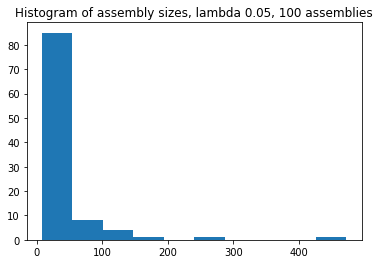

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(nr_of_neurons)
plt.title('Histogram of assembly sizes, lambda 0.05, 100 assemblies')

In [5]:
def test_train_split(data,stim):
    unique, counts = np.unique(stim.flatten(), return_counts=True)
    count_dict=dict(zip(unique, counts))

    keys_with_enough_data=[]
    for key in count_dict.keys():
        if count_dict[key]==2:
            keys_with_enough_data.append(key)

    filtered_stims=np.isin(stim.flatten(),keys_with_enough_data)

    #Arrange data so that responses with the same stimulus are adjacent
    z=stim.flatten()[np.where(filtered_stims)[0]]
    sortd=np.argsort(z)
    istim=np.sort(z)
    X=data[filtered_stims,:]
    out=X[sortd,:].copy()

    x_train=out[::2,:]
    y_train=istim[::2]
    x_test=out[1::2,:]
    y_test=istim[1::2]
    
    return x_train, x_test, y_train, y_test


def corrcoef(x,y):
        '''
        Torch implementation of the full correlation matrix.
        '''
        # calculate covariance matrix of columns
        mean_x = torch.mean(x,0)
        xm = torch.sub(x,mean_x)
        mean_y=torch.mean(y,0)
        ym=torch.sub(y,mean_y)
        c = torch.matmul(x.t(),y)
        c = c / (x.size(0))

        # normalize covariance matrix
        std_x=torch.std(x,0)
        std_y=torch.std(y,0)
        std=torch.matmul(std_x.view(std_x.size()[0],1),std_y.view(1,std_y.size()[0]))
        c = c.div(std)
        return c
    
def evaluate_model(x_train,x_test):
    corr_mat=np.zeros((x_train.shape[0],x_train.shape[0]))
    for j in range(0,x_train.shape[0]):
        for i in range(0,x_test.shape[0]):
            corr_mat[j,i]=np.corrcoef(x_train[j,:],x_test[i,:])[0,1]
    print(np.mean(np.argmax(corr_mat, axis=0) == np.arange(0,x_train.shape[0],1,int)))
    
def evaluate_model_torch(x_train,x_test):
    x_train=torch.cuda.FloatTensor(x_train).t()
    x_test=torch.cuda.FloatTensor(x_test).t()
    corr_mat=np.array(corrcoef(x_train,x_test).cpu())
    #print(corr_mat.size())

    print(np.mean(np.argmax(corr_mat, axis=0) == np.arange(0,x_train.size()[1],1,int)))
    
stim=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['istim'][0][0]
x_train, x_test, y_train, y_test=test_train_split(np.array(X),stim)
print(x_train.shape)
#evaluate_model_torch(x_train,x_test)
#evaluate_model(x_train,x_test)
#x_train, x_test, y_train, y_test=test_train_split(np.array(V.t()),stim)
#evaluate_model_torch(x_train,x_test)

(2800, 10103)


In [ ]:
spont=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['spont']
print(spont)

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(range(0,100),cost_lst)

In [ ]:
neurons_100=np.load('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11_100_neuron_distributions.npy')
print(neurons_100.shape)
topics_100=np.load('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11_100_topic_distributions.npy')
print(topics_100.shape)

total_100=topics_100@neurons_100
print(total_100.shape)

In [ ]:
x_train, x_test, y_train, y_test=test_train_split(topics_100,stim)
evaluate_model_torch(x_train,x_test)

In [24]:
pcs=PCA(n_components=100).fit_transform(X)
print(pcs.shape)
x_train, x_test, y_train, y_test=test_train_split(pcs,stim)
evaluate_model_torch(x_train,x_test)

(5880, 100)
0.3271428571428571
